In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("./multiscale-ssh")))  # replace with real path

from UNet import UNet  # or from unet import UNetSimple if you prefer the smaller version
from loss_function import CombinedLoss

In [3]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
# import gcm_filters
import random

warnings.filterwarnings("ignore")

# importlib.reload(preprocessing)
# from preprocessing import preprocess_data

# from model_eval_plotting import evaluate_model
# from model_eval_plotting import plot_predictions_vs_targets

# from CNN_setup import SimpleCNN
# from CNN_setup import TensorDataset

# from gcm_filtering import filter_inputs_dataset
# from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

# Data Pre-processing

In [4]:
ds_HR1 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_yr1.zarr", engine="zarr", chunks={}
) 
ds_HR2 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_yr2.zarr", engine="zarr", chunks={}
) 
ds_HR3 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_yr3.zarr", engine="zarr", chunks={}
) 
ds_HR4 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_yr4.zarr", engine="zarr", chunks={}
) 
ds_HR5 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_HR_southAtlantic_every10TimeSteps_yr5.zarr", engine="zarr", chunks={}
) 
datasets = [ds_HR1, ds_HR2, ds_HR3, ds_HR4, ds_HR5]

# Concatenate along the 'time' dimension
combined_HR = xr.concat(datasets, dim='time')
combined_HR

<xarray.Dataset> Size: 109MB
Dimensions:   (time: 185, yt_ocean: 163, xt_ocean: 150)
Coordinates:
  * time      (time) object 1kB 0181-01-01 12:00:00 ... 0185-12-26 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    q_ref     (time, yt_ocean, xt_ocean) float32 18MB dask.array<chunksize=(19, 82, 75), meta=np.ndarray>
    slp       (time, yt_ocean, xt_ocean) float32 18MB dask.array<chunksize=(19, 82, 75), meta=np.ndarray>
    sst       (time, yt_ocean, xt_ocean) float32 18MB dask.array<chunksize=(19, 82, 75), meta=np.ndarray>
    t_ref     (time, yt_ocean, xt_ocean) float32 18MB dask.array<chunksize=(19, 82, 75), meta=np.ndarray>
    u_rel     (time, yt_ocean, xt_ocean) float32 18MB dask.array<chunksize=(19, 82, 75), meta=np.ndarray>
    v_rel     (time, yt_ocean, xt_ocean) float32 18MB dask.array<chunksize=(19, 82, 75), meta=np.ndarray>

In [5]:
# Note that all this data is LR because it is filtered

ds_train1 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr1.zarr", engine="zarr", chunks={}
) 
ds_train2 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr2.zarr", engine="zarr", chunks={}
) 
ds_train3 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr3.zarr", engine="zarr", chunks={}
) 
ds_train4 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr4.zarr", engine="zarr", chunks={}
) 
ds_train5 = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps_yr5.zarr", engine="zarr", chunks={}
) 
datasets = [ds_train1, ds_train2, ds_train3, ds_train4, ds_train5]

# Concatenate along the 'time' dimension
combined_LR = xr.concat(datasets, dim='time')
combined_LR

<xarray.Dataset> Size: 217MB
Dimensions:   (time: 185, yt_ocean: 163, xt_ocean: 150)
Coordinates:
  * time      (time) object 1kB 0181-01-01 12:00:00 ... 0185-12-26 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    q_ref     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    slp       (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    sst       (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    t_ref     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    u_rel     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>
    v_rel     (time, yt_ocean, xt_ocean) float64 36MB dask.array<chunksize=(10, 82, 75), meta=np.ndarray>

# Prepare Training/Testing Data

In [6]:
# Total number of samples
n_samples = len(combined_HR.time)  # Assuming 'time' is the dimension

# Generate random indices
indices = np.arange(n_samples)
np.random.shuffle(indices)

# Split indices for training, validation, and testing
train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Select data using the indices
# HR
train_data_HR = combined_HR.isel(time=train_indices)
val_data_HR = combined_HR.isel(time=val_indices)
test_data_HR = combined_HR.isel(time=test_indices)
# LR
train_data_LR = combined_LR.isel(time=train_indices)
val_data_LR = combined_LR.isel(time=val_indices)
test_data_LR = combined_LR.isel(time=test_indices)

print("Training set size:", len(train_data_HR.time))
print("Validation set size:", len(val_data_HR.time))
print("Testing set size:", len(test_data_HR.time))

Training set size: 129
Validation set size: 27
Testing set size: 29


In [7]:
# Extract HR data
urel_HR_train = train_data_HR.u_rel.values ## training
urel_HR_val = val_data_HR.u_rel.values ## testing
urel_HR_test = test_data_HR.u_rel.values ## validation

# Extract LR data
urel_LR_train = train_data_LR.u_rel.values ## training
urel_LR_val = val_data_LR.u_rel.values ## testing
urel_LR_test = test_data_LR.u_rel.values ## validation

# Training U-Net

In [8]:
x_train = torch.tensor(urel_LR_train, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
y_train = torch.tensor(urel_HR_train, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

x_val = torch.tensor(urel_LR_val, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
y_val = torch.tensor(urel_HR_val, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

x_test = torch.tensor(urel_LR_test, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)
y_test = torch.tensor(urel_HR_test, dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)

In [9]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [10]:
model = UNet()
model

UNet(
  (enc_conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv1_1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv2_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (enc_conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [11]:
criterion = CombinedLoss(alpha=5.0)  # Can tweak alpha as desired
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [12]:
train_losses = []
val_losses = []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.float()
        y_batch = y_batch.float()
        
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.float()
            y_batch = y_batch.float()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1, Train Loss: 61.7899, Val Loss: 70.6181
Epoch 2, Train Loss: 56.5105, Val Loss: 70.4713
Epoch 3, Train Loss: 47.2932, Val Loss: 69.2895
Epoch 4, Train Loss: 42.5472, Val Loss: 66.5467
Epoch 5, Train Loss: 41.9444, Val Loss: 62.1218
Epoch 6, Train Loss: 52.6889, Val Loss: 57.3160
Epoch 7, Train Loss: 39.9708, Val Loss: 50.6794
Epoch 8, Train Loss: 40.6119, Val Loss: 45.1692
Epoch 9, Train Loss: 35.9718, Val Loss: 40.0572
Epoch 10, Train Loss: 41.9917, Val Loss: 38.5149


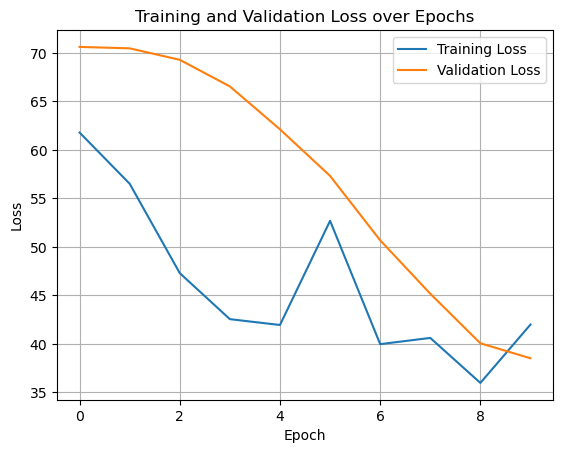

In [13]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Testing U-Net

In [14]:
model.eval()
x_sample, y_sample, y_pred_sample = [], [], []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.float()
        y_batch = y_batch.float()
        y_pred = model(x_batch)

        x_sample.append(x_batch)
        y_sample.append(y_batch)
        y_pred_sample.append(y_pred)

# Concatenate batches into full tensors
x_sample = torch.cat(x_sample)
y_sample = torch.cat(y_sample)
y_pred_sample = torch.cat(y_pred_sample)

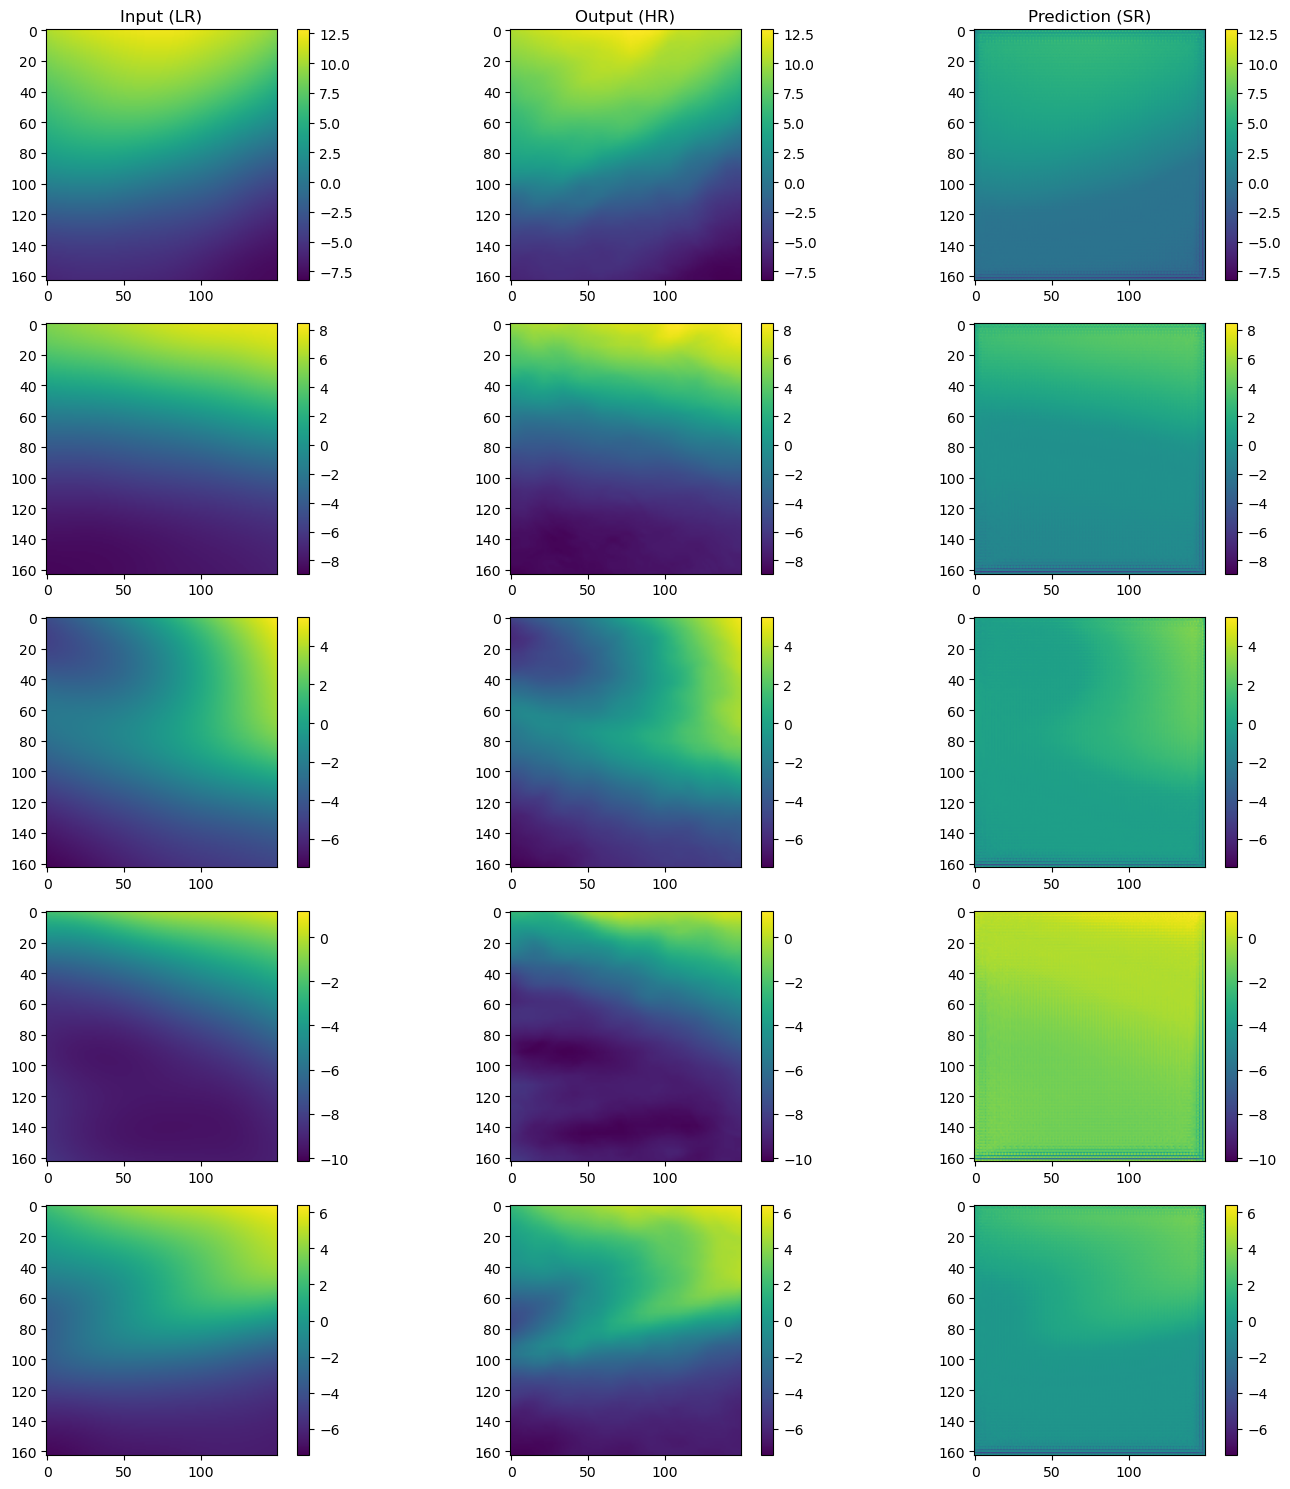

In [15]:
num_samples = 5

# Create figure with 5 rows and 3 columns
fig, axs = plt.subplots(num_samples, 3, figsize=(15, 3 * num_samples))

# Now plot all images with shared vmin/vmax
for i in range(num_samples):
    d1 = x_test.squeeze(1)[i,:,:].numpy()
    d2 = y_test.squeeze(1)[i,:,:].numpy()
    d3 = y_pred.squeeze(1)[i,:,:].numpy()

    # Min/Max Calculation
    vmin = min(d1.min().item(), d2.min().item(), d3.min().item())
    vmax = max(d1.max().item(), d2.max().item(), d3.max().item())
    
    # Input (LR)
    im1 = axs[i, 0].imshow(d1, cmap='viridis', vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 0].set_title('Input (LR)')
    plt.colorbar(im1, ax=axs[i, 0], fraction=0.046, pad=0.04)

    # Output (HR)
    im2 = axs[i, 1].imshow(d2, cmap='viridis', vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 1].set_title('Output (HR)')
    plt.colorbar(im2, ax=axs[i, 1], fraction=0.046, pad=0.04)

    # Prediction (SR)
    im3 = axs[i, 2].imshow(d3, cmap='viridis', vmin=vmin, vmax=vmax)
    if i == 0:
        axs[i, 2].set_title('Prediction (SR)')
    plt.colorbar(im3, ax=axs[i, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

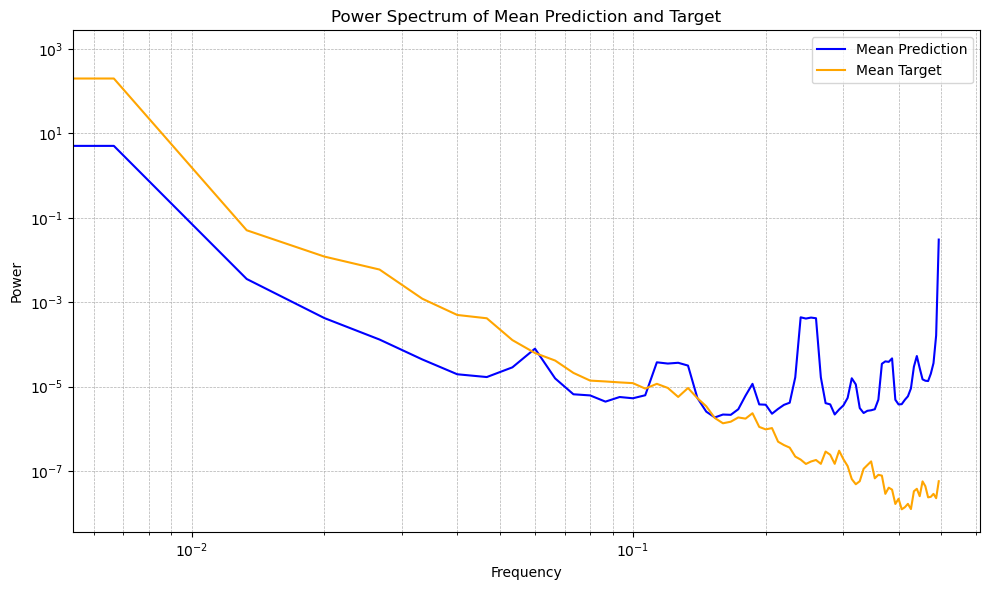

In [16]:
# Define dimensions and coordinates
dims = ['yt_ocean', 'xt_ocean']
coords = {
    'yt_ocean': range(y_pred_sample.shape[-2]),  # Replace with actual coordinates if available
    'xt_ocean': range(y_pred_sample.shape[-1])   # Replace with actual coordinates if available
}

# Compute the mean prediction and target across samples
mean_prediction = y_pred_sample.squeeze(1).mean(dim=0)  # Squeeze to remove the channel dimension and compute mean
mean_target = y_sample.squeeze(1).mean(dim=0)

# Convert to xarray.DataArray
mean_prediction_da = xr.DataArray(mean_prediction.numpy(), dims=dims, coords=coords)
mean_target_da = xr.DataArray(mean_target.numpy(), dims=dims, coords=coords)

# Compute power spectrum for mean prediction and target
ps_pred = xrft.power_spectrum(mean_prediction_da, dim='xt_ocean', window=True).mean(dim='yt_ocean')
ps_targ = xrft.power_spectrum(mean_target_da, dim='xt_ocean', window=True).mean(dim='yt_ocean')

# Plot power spectra
plt.figure(figsize=(10, 6))
plt.plot(ps_pred.freq_xt_ocean, ps_pred, label='Mean Prediction', color='blue')
plt.plot(ps_targ.freq_xt_ocean, ps_targ, label='Mean Target', color='orange')

# Configure the plot
plt.title("Power Spectrum of Mean Prediction and Target")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(loc='best')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()

# Display the plot
plt.show()


# Error Analysis

In [17]:
predictions = y_pred_sample.squeeze(1)
dims = ['sample', 'yt_ocean', 'xt_ocean']
coords = {
    'sample': range(predictions.shape[0]),
    'yt_ocean': range(predictions.shape[-2]),  
    'xt_ocean': range(predictions.shape[-1])
}
prediction_da = xr.DataArray(predictions.numpy(), dims=dims, coords=coords)
prediction_da

<xarray.DataArray (sample: 29, yt_ocean: 163, xt_ocean: 150)> Size: 3MB
array([[[ 1.2336395 ,  1.8870566 ,  2.2057998 , ...,  2.3769407 ,
          1.9470038 ,  0.8051185 ],
        [ 0.25895166,  1.8052336 ,  2.8539987 , ...,  3.4813993 ,
          2.5710945 ,  2.490367  ],
        [ 0.994401  ,  1.6138111 ,  2.3607411 , ...,  3.237368  ,
          3.0497541 ,  1.2809594 ],
        ...,
        [-0.57182133, -0.4897408 , -0.44669467, ..., -1.493629  ,
         -2.6239204 , -0.9818866 ],
        [-1.6137943 , -2.6849341 , -2.5281053 , ..., -3.8988044 ,
         -3.4827206 , -2.0340037 ],
        [-0.2795737 ,  0.0925363 , -0.64357936, ..., -0.48758903,
         -2.3003254 , -0.74624527]],

       [[ 0.6754449 ,  0.93402743,  1.3474678 , ...,  2.0384717 ,
          1.6475974 ,  0.69737875],
        [ 0.5292591 ,  1.3014071 ,  2.1314828 , ...,  3.0935953 ,
          2.204654  ,  2.0711868 ],
        [ 0.66979265,  1.3493204 ,  1.5632422 , ...,  3.1807642 ,
          2.8313637 ,  1.2718571 ],
...
        [-1.1307181 , -1.0362165 , -1.198364  , ..., -1.6513548 ,
         -2.6814876 , -1.046627  ],
        [-2.9697518 , -4.608844  , -4.352228  , ..., -4.1627626 ,
         -3.6280792 , -2.2630296 ],
        [-0.7131964 , -0.18728767, -1.1171432 , ..., -0.5124362 ,
         -2.4692721 , -0.8110366 ]],

       [[-0.12109609, -0.09329683, -0.12231621, ...,  0.45655894,
          0.32004026,  0.14478083],
        [-0.3903852 , -0.5009963 ,  0.52573544, ...,  1.2113081 ,
          1.0951291 ,  0.5648505 ],
        [-0.565943  , -0.43118292, -0.629893  , ...,  1.3961569 ,
          1.3463701 ,  0.65168047],
        ...,
        [-0.554113  , -0.50822824, -0.46665072, ..., -0.5659379 ,
         -1.6233647 , -0.49548006],
        [-1.6848532 , -2.7550297 , -2.5297987 , ..., -2.4755461 ,
         -2.3284605 , -1.273012  ],
        [-0.30277866,  0.09696899, -0.62116253, ...,  0.09145668,
         -1.1391052 , -0.23025599]]], dtype=float32)
Coordinates:
  * sample    (sample) int64 232B 0 1 2 3 4 5 6 7 8 ... 21 22 23 24 25 26 27 28
  * yt_ocean  (yt_ocean) int64 1kB 0 1 2 3 4 5 6 ... 156 157 158 159 160 161 162
  * xt_ocean  (xt_ocean) int64 1kB 0 1 2 3 4 5 6 ... 143 144 145 146 147 148 149

In [18]:
targets = y_sample.squeeze(1)
dims = ['sample', 'yt_ocean', 'xt_ocean']
coords = {
    'sample': range(targets.shape[0]),
    'yt_ocean': range(targets.shape[-2]),  
    'xt_ocean': range(targets.shape[-1])
}
target_da = xr.DataArray(targets.numpy(), dims=dims, coords=coords)
target_da

<xarray.DataArray (sample: 29, yt_ocean: 163, xt_ocean: 150)> Size: 3MB
array([[[10.253249 , 10.305941 , 10.362219 , ..., 10.036346 ,
          9.914914 ,  9.805972 ],
        [10.186151 , 10.240708 , 10.299315 , ...,  9.942137 ,
          9.8265915,  9.718165 ],
        [10.122401 , 10.175921 , 10.233419 , ...,  9.84925  ,
          9.736909 ,  9.624538 ],
        ...,
        [-6.0409484, -6.0258074, -6.003668 , ..., -8.133471 ,
         -8.126597 , -8.117811 ],
        [-6.083482 , -6.062027 , -6.032681 , ..., -8.160128 ,
         -8.142696 , -8.124695 ],
        [-6.118947 , -6.087611 , -6.0539527, ..., -8.155391 ,
         -8.138763 , -8.114294 ]],

       [[ 5.7579618,  5.7805758,  5.812077 , ...,  8.398789 ,
          8.387514 ,  8.374791 ],
        [ 5.6395106,  5.6682734,  5.704154 , ...,  8.369635 ,
          8.35681  ,  8.345973 ],
        [ 5.5299087,  5.561717 ,  5.599998 , ...,  8.346915 ,
          8.328457 ,  8.313305 ],
...
        [-8.479574 , -8.531451 , -8.5881   , ..., -8.240545 ,
         -8.208368 , -8.180074 ],
        [-8.468506 , -8.511136 , -8.563451 , ..., -8.250334 ,
         -8.21693  , -8.189593 ],
        [-8.456205 , -8.49857  , -8.549621 , ..., -8.264059 ,
         -8.235587 , -8.211476 ]],

       [[-6.616973 , -6.6268077, -6.6331143, ...,  1.8914188,
          1.8700788,  1.8474164],
        [-6.639673 , -6.6535244, -6.661931 , ...,  1.8027169,
          1.7826359,  1.7625375],
        [-6.670922 , -6.686359 , -6.697507 , ...,  1.7139196,
          1.6964661,  1.6786551],
        ...,
        [-5.9183946, -5.9112177, -5.9011807, ..., -5.509175 ,
         -5.4996815, -5.488637 ],
        [-5.9885983, -5.987726 , -5.9843397, ..., -5.4701486,
         -5.46053  , -5.4511504],
        [-6.0682287, -6.0739713, -6.078862 , ..., -5.4192204,
         -5.4104414, -5.402222 ]]], dtype=float32)
Coordinates:
  * sample    (sample) int64 232B 0 1 2 3 4 5 6 7 8 ... 21 22 23 24 25 26 27 28
  * yt_ocean  (yt_ocean) int64 1kB 0 1 2 3 4 5 6 ... 156 157 158 159 160 161 162
  * xt_ocean  (xt_ocean) int64 1kB 0 1 2 3 4 5 6 ... 143 144 145 146 147 148 149

In [19]:
def r2_score(y_true, y_pred):
    y_true = y_true.values.flatten()
    y_pred = y_pred.values.flatten()
    y_true_mean = np.mean(y_true)
    ss_total = np.sum((y_true - y_true_mean) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    return 1 - ss_res / ss_total

def r_corr(y_true, y_pred):
    y_true = y_true.values.flatten()
    y_pred = y_pred.values.flatten()
    y_true_mean = np.mean(y_true)
    y_pred_mean = np.mean(y_pred)
    vx = y_true - y_true_mean
    vy = y_pred - y_pred_mean
    return np.sum(vx * vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2)))

In [20]:
r2 = r2_score(target_da, prediction_da)
r2

np.float32(-0.5489744)

In [21]:
corr = r_corr(target_da, prediction_da)
corr

np.float32(0.9024131)

In [22]:
# Per pixel mean absolute error (MAE) statistics

# y_true and y_pred are numpy arrays of shape (N, H, W)
# N: number of samples, H: height, W: width

# 1. Compute absolute errors (N, H, W)
abs_errors = np.abs(target_da - prediction_da)

# 2. For each pixel (h,w), get distribution over N samples
# Example stats:

# Mean absolute error per pixel: shape (H, W)
mae_per_pixel = np.mean(abs_errors, axis=0)

# Median absolute error per pixel
median_ae_per_pixel = np.median(abs_errors, axis=0)

# Std deviation of absolute error per pixel
std_ae_per_pixel = np.std(abs_errors, axis=0)

In [23]:
flat_mae = mae_per_pixel.values.flatten()

summary = {
    'Mean MAE': np.mean(flat_mae),
    'Median MAE': np.median(flat_mae),
    'Std MAE': np.std(flat_mae),
    'Min MAE': np.min(flat_mae),
    'Max MAE': np.max(flat_mae),
    '25th Percentile': np.percentile(flat_mae, 25),
    '75th Percentile': np.percentile(flat_mae, 75)
}

summary

{'Mean MAE': np.float32(4.347678),
 'Median MAE': np.float32(4.1690173),
 'Std MAE': np.float32(1.3240086),
 'Min MAE': np.float32(1.7744894),
 'Max MAE': np.float32(7.0505786),
 '25th Percentile': np.float32(3.0256686),
 '75th Percentile': np.float32(5.673527)}